In [1]:
import numpy as np 
import pandas as pd 
import os

from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import RMSprop
from keras.layers import Dropout
from sklearn.model_selection import train_test_split

2024-02-23 05:52:26.572939: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-23 05:52:26.573041: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-23 05:52:26.736437: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# **Data Preprocessing**

In [2]:
df = pd.read_csv('/kaggle/input/Nietzsche_works_corpus.csv')
df.head()

,Unnamed: 0,book_title,publishing_date,text,text_clean
0,0,Beyond Good and Evil,1886,PREFACE\r\n BEYOND GOOD AND EVIL\r\n\r\n ...,preface beyond good evil chapter i prejudices ...
1,1,Thus Spake Zarathustra: A Book for All and None,1885,THUS SPAKE ZARATHUSTRA.\r\n\r\n FIRST PART...,thus spake zarathustra first part zarathustras...
2,2,Thoughts out of Season,1909,"PREFACE.\r\n\r\n\r\n1.\r\n\r\nWe are unknown, ...",preface 1 unknown knowers ourselves good reaso...
3,3,The Dawn of Day,1881,PREFACE\r\n\r\n\r\n1\r\n\r\nAs it is my intent...,preface 1 intention within short time confront...
4,4,Homer and Classical Philology,1868,PREFACE.\r\n\r\n\r\n1.\r\n\r\nConcerning great...,preface 1 concerning great things one either s...


In [3]:
text = df[df['book_title']=='Beyond Good and Evil']['text_clean'][0]
print(len(text))

251619


In [4]:
# Getting the unique characters in the text
unique_characters = set(text)

print(len(unique_characters))
print(unique_characters)

38
{'f', ' ', '1', 'b', 'l', 'p', 'r', '3', 'i', 'a', 'u', 'h', '2', 't', 'w', 's', '0', '_', '8', '7', 'e', 'x', 'd', 'g', 'v', '9', 'z', '5', 'j', 'k', '4', 'q', 'c', 'o', 'n', 'y', 'm', '6'}


In [5]:
# Mapping characters to integers
char_to_index = {char: i for i, char in enumerate(set(text))}
index_to_char = {i: char for i, char in enumerate(set(text))}

In [6]:
# Convert the text to a sequence of indices
text_as_indices = [char_to_index[char] for char in text]

In [7]:
# Setting the parameters
sequence_length = 80
num_neurons = 128
num_distinct_chars = len(unique_characters)

# Generate input sequences and corresponding labels
X = []
y = []

for i in range(0, len(text_as_indices) - sequence_length, 1):
    sequence_in = text_as_indices[i:i + sequence_length]
    sequence_out = text_as_indices[i + sequence_length]
    X.append(sequence_in)
    y.append(sequence_out)

# Convert to numpy arrays
X = np.array(X)
y = np.array(y)

# Reshape X
X = np.reshape(X, (X.shape[0], sequence_length, 1))

# Normalize the data to values between 0 and 1
X = X / float(len(unique_characters))

In [8]:
print(X.shape)
print(y.shape)

(251539, 80, 1)
(251539,)


In [9]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.05, random_state=1)

# **Creating the Many to One Model**

In [10]:
# Create the model
model = Sequential()
model.add(LSTM(num_neurons, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(num_neurons, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(num_neurons, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(num_distinct_chars, activation='softmax'))

# Set initial weights
initial_weights = 0.05
for layer in model.layers:
    for weight in layer.get_weights():
        weight[:] = initial_weights

# Compile the model with RMSProp
optimizer = RMSprop(learning_rate=0.01)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 80, 128)           66560     
                                                                 
 dropout (Dropout)           (None, 80, 128)           0         
                                                                 
 lstm_1 (LSTM)               (None, 80, 128)           131584    
                                                                 
 dropout_1 (Dropout)         (None, 80, 128)           0         
                                                                 
 lstm_2 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 38)                4

In [11]:
# Train the model
history = model.fit(X_train, y_train, epochs=30, batch_size=128, validation_data=(X_val, y_val))

Epoch 1/30
1867/1867 [==============================] - 701s 373ms/step - loss: 2.9432 - accuracy: 0.1343 - val_loss: 2.9213 - val_accuracy: 0.1330
Epoch 2/30
1867/1867 [==============================] - 703s 377ms/step - loss: 2.9208 - accuracy: 0.1363 - val_loss: 2.9215 - val_accuracy: 0.1330
Epoch 3/30
1867/1867 [==============================] - 703s 377ms/step - loss: 2.8367 - accuracy: 0.1625 - val_loss: 2.6217 - val_accuracy: 0.2207
Epoch 4/30
1867/1867 [==============================] - 703s 377ms/step - loss: 2.4584 - accuracy: 0.2591 - val_loss: 2.1615 - val_accuracy: 0.3412
Epoch 5/30
1867/1867 [==============================] - 699s 375ms/step - loss: 2.1825 - accuracy: 0.3371 - val_loss: 1.9629 - val_accuracy: 0.3993
Epoch 6/30
1867/1867 [==============================] - 701s 375ms/step - loss: 2.0504 - accuracy: 0.3770 - val_loss: 1.8695 - val_accuracy: 0.4289
Epoch 7/30
1867/1867 [==============================] - 702s 376ms/step - loss: 1.9738 - accuracy: 0.3979 - val_

# **Displaying the Plots**

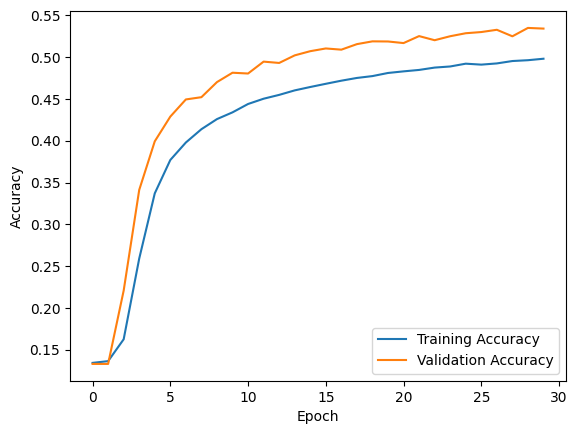

In [12]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy to epoch
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

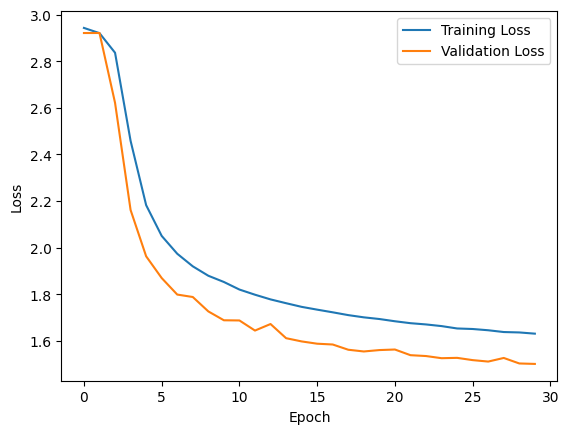

In [13]:
# Plot loss to epoch
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# **Predicting Characters**

In [14]:
# Number of characters being predicted
num_predictions = 50

# Select a random starting point
start_index = np.random.randint(0, len(text) - sequence_length - num_predictions)

# Extract a 40-character sequence
input_sequence = text[start_index : start_index + sequence_length]

# Prepare input for prediction
input_sequence_indices = [char_to_index[char] for char in input_sequence]
input_sequence_array = np.reshape(input_sequence_indices, (1, sequence_length, 1))

# Normalize the data to values between 0 and 1
input_sequence_array = input_sequence_array / float(len(unique_characters))

# Generate predictions
predicted_sequence_indices = []
for _ in range(num_predictions):
    predictions = model.predict(input_sequence_array, verbose=0)[0]
    predicted_index = np.argmax(predictions)
    predicted_char = index_to_char[predicted_index]
    
    # Append the predicted character to the sequence
    predicted_sequence_indices.append(predicted_index)
    input_sequence_indices.append(predicted_index)
    input_sequence_indices = input_sequence_indices[1:]
    
    # Prepare the input for the next prediction
    input_sequence_array = np.reshape(input_sequence_indices, (1, sequence_length, 1))
    
    # Normalize the data to values between 0 and 1
    input_sequence_array = input_sequence_array / float(len(unique_characters))

# Convert predicted indices back to characters
predicted_sequence = ''.join([index_to_char[index] for index in predicted_sequence_indices])

# Print the result
print("Original Sequence:", input_sequence)
print("Predicted Sequence:", predicted_sequence)

Original Sequence: nts sometimes night owls work even full day yea necessary even scarecrows and ne
Predicted Sequence: w sufficiently sufficiently sufficiently sufficien
